In [1]:
import numpy as np
import lsst.eotest.image_utils as imutils
import lsst.afw.image as afwImage
from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.AmplifierGeometry import parse_geom_kwd

def make_ccd_mosaic(infile, bias_frame=None, gains=None, fit_order=1,dm_view=False):
    """Combine amplifier image arrays into a single mosaic CCD image array."""
    ccd = MaskedCCD(infile, bias_frame=bias_frame)
    datasec = parse_geom_kwd(ccd.amp_geom[1]['DATASEC'])
    nx_segments = 8
    ny_segments = 2
    nx = nx_segments*(datasec['xmax'] - datasec['xmin'] + 1)
    ny = ny_segments*(datasec['ymax'] - datasec['ymin'] + 1)
    mosaic = np.zeros((ny, nx), dtype=np.float32) # this array has [0,0] in the upper right corner on LCA-13381 view o
     
    for ypos in range(ny_segments):
        for xpos in range(nx_segments):
            amp = ypos*nx_segments + xpos + 1      
            detsec = parse_geom_kwd(ccd.amp_geom[amp]['DETSEC'])
            xmin = nx - max(detsec['xmin'], detsec['xmax'])
            xmax = nx - min(detsec['xmin'], detsec['xmax']) + 1
            ymin = ny - max(detsec['ymin'], detsec['ymax'])
            ymax = ny - min(detsec['ymin'], detsec['ymax']) + 1
            #
            # Extract bias-subtracted image for this segment - overscan not corrected, since we don't pass overscan he
            #
            segment_image = ccd.unbiased_and_trimmed_image(amp, fit_order=fit_order)
            subarr = segment_image.getImage().getArray()
            #
            # Determine flips in x- and y- direction
            #
            if detsec['xmax'] > detsec['xmin']: # flip in x-direction
              subarr = subarr[:, ::-1]
            if detsec['ymax'] > detsec['ymin']: # flip in y-direction
              subarr = subarr[::-1, :]
            #
            # Convert from ADU to e-
            #
            if gains is not None:
              subarr *= gains[amp]
            #
            # Set sub-array to the mosaiced image
            #
            mosaic[ymin:ymax, xmin:xmax] = subarr  
    if dm_view:
      # transpose and rotate by -90 to get a mosaic ndarray that will look like the LCA-13381 view with matplotlib(origin='lower') rotated CW by 90 for DM view
      mosaicprime = np.zeros((ny, nx), dtype=np.float32) 
      mosaicprime[:,:] = np.rot90(np.transpose(mosaic),k=-1)    
      image = afwImage.ImageF(mosaicprime)  
    else:
      # transpose and rotate by 180 to get a mosaic ndarray that will look like the LCA-13381 view with matplotlib(origin='lower')
      mosaicprime = np.zeros((nx, ny), dtype=np.float32) 
      mosaicprime[:,:] = np.rot90(np.transpose(mosaic),k=2)    
      image = afwImage.ImageF(mosaicprime)  
    
    return image
      

In [8]:
itl = "/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-205_median_sflat.fits"
etv = "/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-024/11317/dark_defects_raft/v0/88004/E2V-CCD250-382_median_sflat.fits"

################
datasource = etv
image = make_ccd_mosaic(datasource).getArray()
np.save("etv.npy",image)

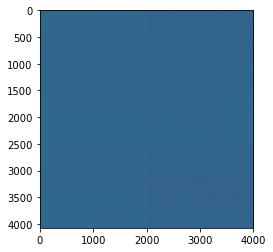

In [6]:
import matplotlib.pylab as plt

plt.imshow(image)